In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import STL
from tsfeatures import *
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from fpppy.utils import plot_series

plt.style.use("ggplot")
import matplotlib as mpl
from cycler import cycler

mpl.rcParams["axes.prop_cycle"] = cycler(color=mpl.cm.tab20(range(20)))

pd.set_option("display.precision", 3)

# Table of contents
1. [Some simple statistics](#some-simple-statistics)
2. [ACF features](#acf-features)
3. [STL features](#stl-features)
5. [Exploring Australian tourism data](#exploring-australian-tourism-data)
6. [Exercises](#exercises)

# [Some simple statistics](https://otexts.com/fpppy/nbs/04-features.html#some-simple-statistics)

In [2]:
aus_tourism = pd.read_csv("data/aus_tourism.csv", parse_dates=["ds"])
aus_tourism.head()

,unique_id,ds,y
0,Adelaide-South Australia-Business,1998-03-31,135.078
1,Adelaide-South Australia-Business,1998-06-30,109.987
2,Adelaide-South Australia-Business,1998-09-30,166.035
3,Adelaide-South Australia-Business,1998-12-31,127.160
4,Adelaide-South Australia-Business,1999-03-31,137.449


In [3]:
mean_df = aus_tourism.groupby("unique_id", as_index=False)["y"].mean()
mean_df.sort_values(by="y").head(10)

,unique_id,y
158,Kangaroo Island-South Australia-Other,0.340
182,MacDonnell-Northern Territory-Other,0.449
294,Wilderness West-Tasmania-Other,0.478
34,Barkly-Northern Territory-Other,0.632
86,Clare Valley-South Australia-Other,0.898
38,Barossa-South Australia-Other,1.022
154,Kakadu Arnhem-Northern Territory-Other,1.043
170,Lasseter-Northern Territory-Other,1.136
298,Wimmera-Victoria-Other,1.146
183,MacDonnell-Northern Territory-Visiting,1.175


Summary stats without using `tsfeatures`

In [4]:
summary_stats = aus_tourism.groupby("unique_id", as_index=False)["y"].agg(
    [
        ("min", "min"),
        ("p25", lambda x: np.percentile(x, 25)),
        ("median", "median"),
        ("p75", lambda x: np.percentile(x, 75)),
        ("max", "max"),
    ]
)
summary_stats.head(10)

,unique_id,min,p25,median,p75,max
0,Adelaide Hills-South Australia-Business,0.000,0.000,1.255,3.920,28.602
1,Adelaide Hills-South Australia-Holiday,0.000,5.768,8.516,14.060,35.751
2,Adelaide Hills-South Australia-Other,0.000,0.000,0.908,2.093,8.953
3,Adelaide Hills-South Australia-Visiting,0.778,8.908,12.207,16.806,81.102
4,Adelaide-South Australia-Business,68.725,133.893,152.577,176.936,242.494
5,Adelaide-South Australia-Holiday,108.033,134.627,153.945,172.257,223.557
6,Adelaide-South Australia-Other,25.902,43.866,53.809,62.523,107.495
7,Adelaide-South Australia-Visiting,136.611,178.916,205.582,229.299,269.536
8,Alice Springs-Northern Territory-Business,1.008,9.133,13.324,18.456,34.077
9,Alice Springs-Northern Territory-Holiday,2.809,16.851,31.524,44.784,76.541


With `tsfeatures`

In [5]:
summary_stats = tsfeatures(aus_tourism, freq=4, features=[statistics], scale=False)
summary_stats[["unique_id", "min", "p25", "median", "p75", "max"]].head(10)

,unique_id,min,p25,median,p75,max
0,Adelaide Hills-South Australia-Business,0.000,0.000,1.255,3.920,28.602
1,Adelaide Hills-South Australia-Holiday,0.000,5.768,8.516,14.060,35.751
2,Adelaide Hills-South Australia-Other,0.000,0.000,0.908,2.093,8.953
3,Adelaide Hills-South Australia-Visiting,0.778,8.908,12.207,16.806,81.102
4,Adelaide-South Australia-Business,68.725,133.893,152.577,176.936,242.494
5,Adelaide-South Australia-Holiday,108.033,134.627,153.945,172.257,223.557
6,Adelaide-South Australia-Other,25.902,43.866,53.809,62.523,107.495
7,Adelaide-South Australia-Visiting,136.611,178.916,205.582,229.299,269.536
8,Alice Springs-Northern Territory-Business,1.008,9.133,13.324,18.456,34.077
9,Alice Springs-Northern Territory-Holiday,2.809,16.851,31.524,44.784,76.541


# [ACF features](https://otexts.com/fpppy/nbs/04-features.html#acf-features)

Without `tsfeatures`

In [6]:
acf_feat = aus_tourism.groupby("unique_id", as_index=False)["y"].agg(
    [
        ("x_acf1", lambda x: acf(x, nlags=1)[1]),
        ("x_acf10", lambda x: np.sum(np.square(acf(x, nlags=10)[1:]))),
        ("diff1_acf1", lambda x: acf(np.diff(x, n=1), nlags=1, missing="drop")[1]),
        (
            "diff_acf10",
            lambda x: np.sum(
                np.square(acf(np.diff(x, n=1), nlags=10, missing="drop")[1:])
            ),
        ),
        ("diff2_acf1", lambda x: acf(np.diff(x, n=2), nlags=1, missing="drop")[1]),
        (
            "diff2_acf10",
            lambda x: np.sum(
                np.square(acf(np.diff(x, n=2), nlags=10, missing="drop")[1:])
            ),
        ),
        ("seas_acf1", lambda x: acf(x, nlags=4)[4]),
        ("seas_pacf", lambda x: pacf(x, nlags=4)[4]),
    ]
)
acf_feat.head(10)

,unique_id,x_acf1,x_acf10,diff1_acf1,diff_acf10,diff2_acf1,diff2_acf10,seas_acf1,seas_pacf
0,Adelaide Hills-South Australia-Business,0.071,0.134,-0.580,0.415,-0.750,0.746,-0.063,-0.118
1,Adelaide Hills-South Australia-Holiday,0.131,0.313,-0.536,0.500,-0.716,0.906,0.208,0.191
2,Adelaide Hills-South Australia-Other,0.261,0.330,-0.253,0.317,-0.457,0.392,0.075,0.044
3,Adelaide Hills-South Australia-Visiting,0.139,0.117,-0.472,0.239,-0.626,0.408,0.170,0.138
4,Adelaide-South Australia-Business,0.033,0.131,-0.520,0.463,-0.676,0.741,0.201,0.206
5,Adelaide-South Australia-Holiday,0.046,0.372,-0.343,0.614,-0.487,0.558,0.351,0.347
6,Adelaide-South Australia-Other,0.517,1.154,-0.409,0.383,-0.675,0.792,0.342,0.314
7,Adelaide-South Australia-Visiting,0.068,0.294,-0.394,0.452,-0.518,0.447,0.345,0.332
8,Alice Springs-Northern Territory-Business,0.217,0.367,-0.500,0.381,-0.658,0.587,0.315,0.260
9,Alice Springs-Northern Territory-Holiday,-0.007,2.113,-0.153,2.113,-0.274,1.551,0.729,0.546


With `tsfeatures`

In [7]:
acf_feat = tsfeatures(aus_tourism, freq=4, features=[acf_features])
acf_feat.head(10)

,unique_id,x_acf1,x_acf10,diff1_acf1,diff1_acf10,diff2_acf1,diff2_acf10,seas_acf1
0,Adelaide Hills-South Australia-Business,0.071,0.134,-0.580,0.415,-0.750,0.746,-0.063
1,Adelaide Hills-South Australia-Holiday,0.131,0.313,-0.536,0.500,-0.716,0.906,0.208
2,Adelaide Hills-South Australia-Other,0.261,0.330,-0.253,0.317,-0.457,0.392,0.075
3,Adelaide Hills-South Australia-Visiting,0.139,0.117,-0.472,0.239,-0.626,0.408,0.170
4,Adelaide-South Australia-Business,0.033,0.131,-0.520,0.463,-0.676,0.741,0.201
5,Adelaide-South Australia-Holiday,0.046,0.372,-0.343,0.614,-0.487,0.558,0.351
6,Adelaide-South Australia-Other,0.517,1.154,-0.409,0.383,-0.675,0.792,0.342
7,Adelaide-South Australia-Visiting,0.068,0.294,-0.394,0.452,-0.518,0.447,0.345
8,Alice Springs-Northern Territory-Business,0.217,0.367,-0.500,0.381,-0.658,0.587,0.315
9,Alice Springs-Northern Territory-Holiday,-0.007,2.113,-0.153,2.113,-0.274,1.551,0.729


# [STL features](https://otexts.com/fpppy/nbs/04-features.html#sec-stlfeatures)

Without `tsfeatures` (not generating all listed features)

In [8]:
def get_trend_strength(x, period):
    res_stl = STL(x, period=period, seasonal=13).fit()
    ft = max(0, 1 - np.var(res_stl.resid) / np.var(res_stl.trend + res_stl.resid))

    return ft


def get_seasonal_strength(x, period):
    res_stl = STL(x, period=period, seasonal=13).fit()
    fs = max(0, 1 - np.var(res_stl.resid) / np.var(res_stl.seasonal + res_stl.resid))

    return fs


def get_peak(x, period):
    res_stl = STL(x, period=period, seasonal=13).fit()
    peak = (np.argmax(res_stl.seasonal) + 1) % period
    if peak == 0:
        peak = period

    return peak


def get_trough(x, period):
    res_stl = STL(x, period=period, seasonal=13).fit()
    trough = (np.argmin(res_stl.seasonal) + 1) % period
    if trough == 0:
        trough = period

    return trough


def get_e_acf1(x, period):
    res_stl = STL(x, period=period, seasonal=13).fit()

    return acf(res_stl.resid, nlags=1)[1]


def get_e_acf10(x, period):
    res_stl = STL(x, period=period, seasonal=13).fit()

    return np.sum(np.square(acf(res_stl.resid, nlags=10)[1:]))

In [9]:
stl_feat = aus_tourism.groupby("unique_id", as_index=False)["y"].agg(
    [
        ("trend", lambda x: get_trend_strength(x, period=4)),
        ("seasonal_strength", lambda x: get_seasonal_strength(x, period=4)),
        ("peak", lambda x: get_peak(x, period=4)),
        ("trough", lambda x: get_trough(x, period=4)),
        ("e_acf1", lambda x: get_e_acf1(x, period=4)),
        ("e_acf10", lambda x: get_e_acf10(x, period=4)),
    ]
)
stl_feat.head(10)

,unique_id,trend,seasonal_strength,peak,trough,e_acf1,e_acf10
0,Adelaide Hills-South Australia-Business,0.460,0.168,3,4,-0.594,0.502
1,Adelaide Hills-South Australia-Holiday,0.531,0.295,2,4,-0.456,0.342
2,Adelaide Hills-South Australia-Other,0.590,0.407,2,2,-0.295,0.273
3,Adelaide Hills-South Australia-Visiting,0.487,0.248,4,3,-0.474,0.438
4,Adelaide-South Australia-Business,0.462,0.391,3,1,-0.538,0.577
5,Adelaide-South Australia-Holiday,0.578,0.638,1,2,-0.525,0.600
6,Adelaide-South Australia-Other,0.746,0.209,2,3,-0.368,0.412
7,Adelaide-South Australia-Visiting,0.449,0.476,1,2,-0.504,1.000
8,Alice Springs-Northern Territory-Business,0.552,0.302,3,1,-0.481,0.519
9,Alice Springs-Northern Territory-Holiday,0.379,0.832,3,1,-0.529,0.709


With `tsfeatures`

In [10]:
stl_feat = tsfeatures(aus_tourism, freq=4, features=[stl_features])
stl_feat.head(10)

,unique_id,nperiods,seasonal_period,trend,spike,linearity,curvature,e_acf1,e_acf10,seasonal_strength,peak,trough
0,Adelaide Hills-South Australia-Business,1,4,0.460,3.223e-04,0.278,-0.627,-0.594,0.502,0.168,3,4
1,Adelaide Hills-South Australia-Holiday,1,4,0.531,1.048e-04,1.669,3.925,-0.456,0.342,0.295,2,4
2,Adelaide Hills-South Australia-Other,1,4,0.590,5.346e-05,2.486,1.898,-0.295,0.273,0.407,2,2
3,Adelaide Hills-South Australia-Visiting,1,4,0.487,5.798e-04,3.231,-0.125,-0.474,0.438,0.248,4,3
4,Adelaide-South Australia-Business,1,4,0.462,9.712e-05,-0.106,2.049,-0.538,0.577,0.391,3,1
5,Adelaide-South Australia-Holiday,1,4,0.578,1.717e-05,1.850,3.028,-0.525,0.600,0.638,1,2
6,Adelaide-South Australia-Other,1,4,0.746,2.364e-05,5.548,2.493,-0.368,0.412,0.209,2,3
7,Adelaide-South Australia-Visiting,1,4,0.449,4.824e-05,1.033,2.267,-0.504,1.000,0.476,1,2
8,Alice Springs-Northern Territory-Business,1,4,0.552,5.246e-05,3.299,2.586,-0.481,0.519,0.302,3,1
9,Alice Springs-Northern Territory-Holiday,1,4,0.379,6.707e-06,-1.076,0.634,-0.529,0.709,0.832,3,1


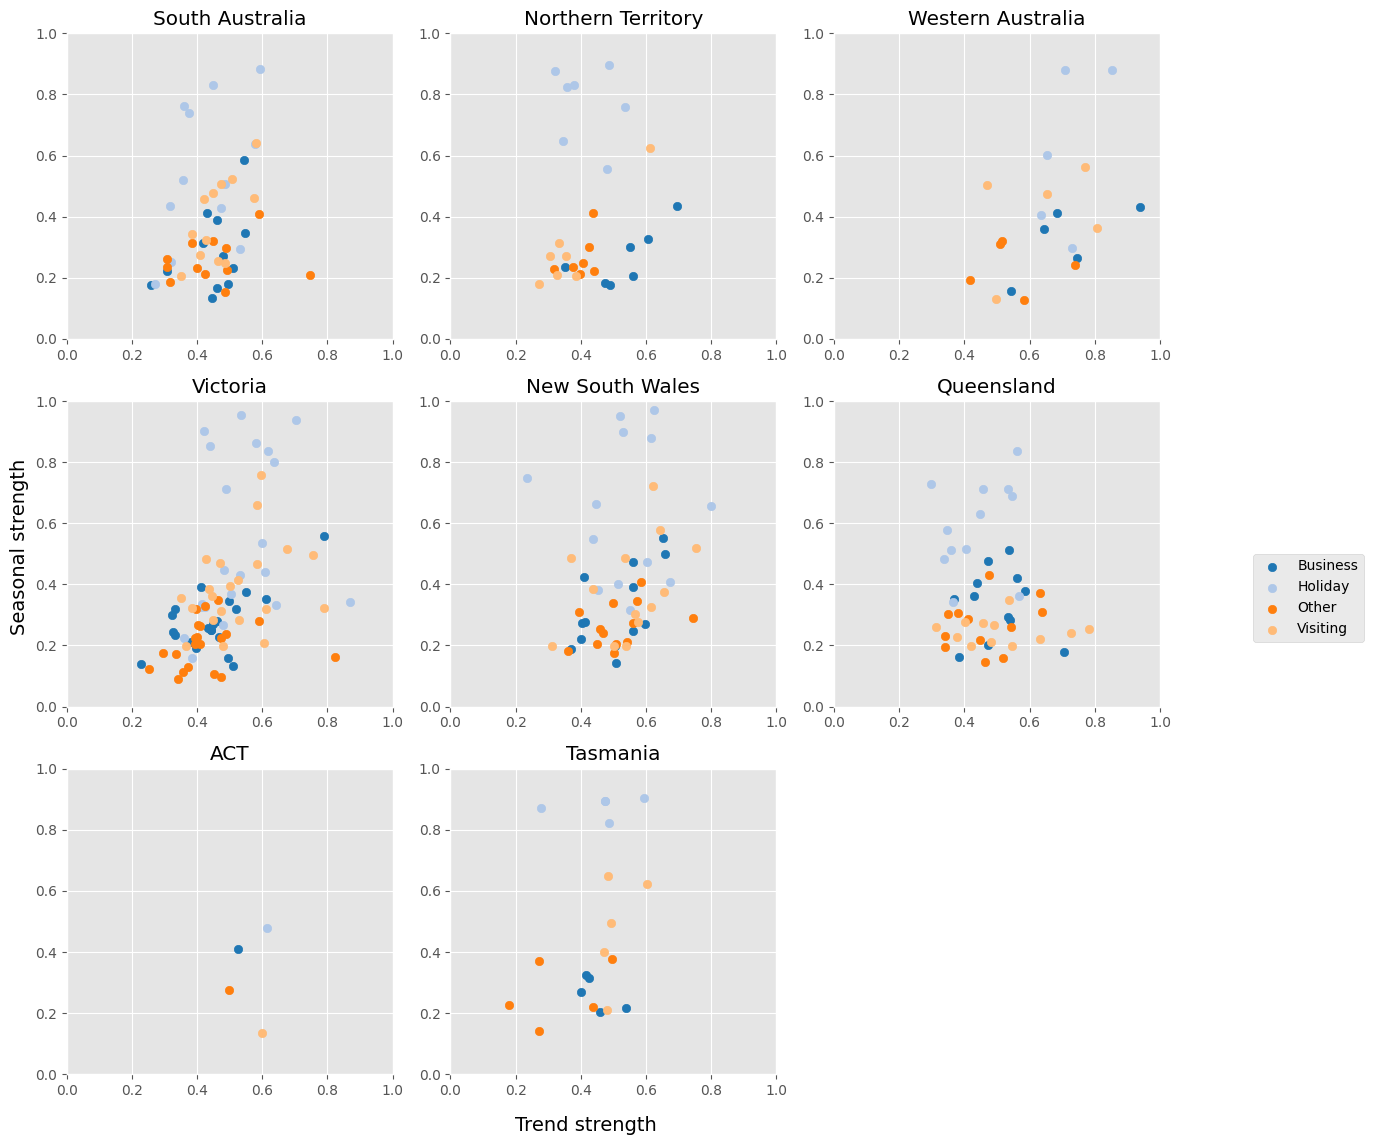

In [11]:
stl_feat[["region", "state", "purpose"]] = stl_feat["unique_id"].str.split(
    "-", expand=True
)

fig, axs = plt.subplots(3, 3, figsize=(12, 12))
axs = axs.flatten()
unique_states = stl_feat["state"].unique()
all_handles = []
all_labels = []
for i, state in enumerate(unique_states):
    state_df = stl_feat[stl_feat["state"] == state].copy()
    ax = axs[i]
    for purpose in state_df["purpose"].unique():
        purpose_df = state_df[state_df["purpose"] == purpose]
        handle = ax.scatter(
            purpose_df["trend"], purpose_df["seasonal_strength"], label=purpose
        )
        if purpose not in all_labels:
            all_handles.append(handle)
            all_labels.append(purpose)
    ax.set_title(state)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
fig.legend(
    all_handles,
    all_labels,
    loc="upper left",
    bbox_to_anchor=(1.05, 0.5),
)
fig.supxlabel("Trend strength", fontsize=14)
fig.supylabel("Seasonal strength", fontsize=14)

# Remove any empty subplots
for j in range(len(unique_states), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

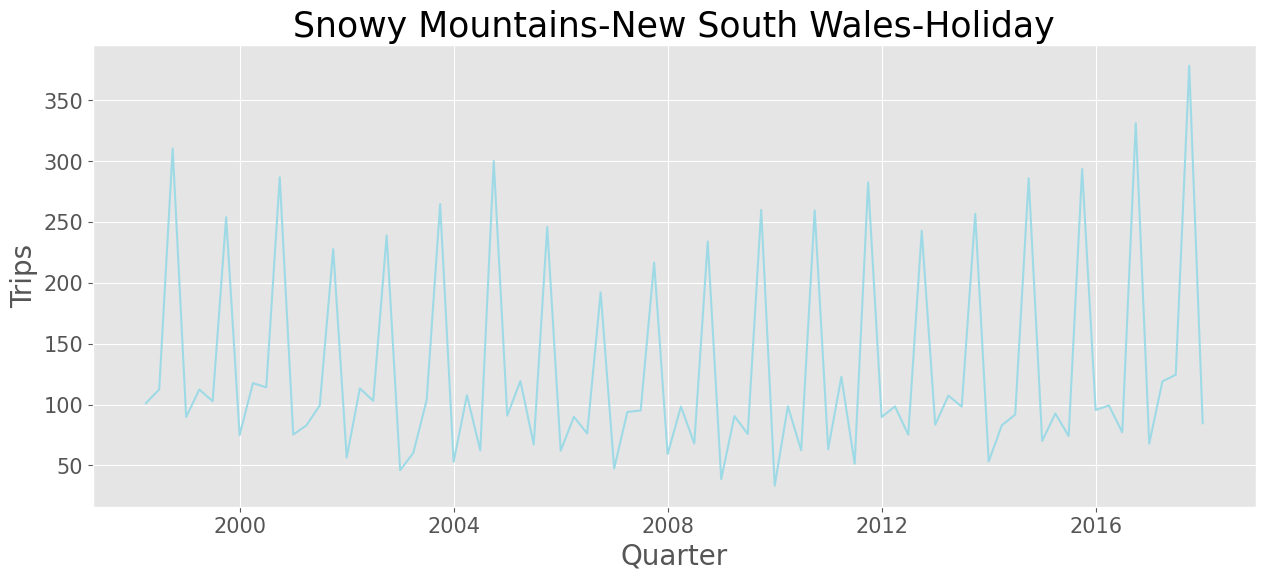

In [12]:
max_seasonal_strength_row = stl_feat.loc[stl_feat["seasonal_strength"].idxmax()]
max_unique_id = max_seasonal_strength_row["unique_id"]
aus_tourism["ds"] = pd.to_datetime(aus_tourism["ds"])
plot_series(
    aus_tourism,
    id_col="unique_id",
    ids=[max_unique_id],
    time_col="ds",
    target_col="y",
    xlabel="Quarter",
    ylabel="Trips",
    title=max_unique_id,
)

# [Exploring Australian tourism data](https://otexts.com/fpppy/nbs/04-features.html#exploring-australian-tourism-data)

In [13]:
all_features = [
    acf_features,
    arch_stat,
    crossing_points,
    entropy,
    flat_spots,
    heterogeneity,
    holt_parameters,
    lumpiness,
    nonlinearity,
    pacf_features,
    stl_features,
    stability,
    hw_parameters,
    unitroot_kpss,
    unitroot_pp,
    series_length,
    hurst,
]
all_feat = tsfeatures(aus_tourism, freq=4, features=all_features)
all_feat.head(10)

,unique_id,hurst,series_length,unitroot_pp,unitroot_kpss,hw_alpha,hw_beta,hw_gamma,stability,nperiods,...,entropy,crossing_points,arch_lm,x_acf1,x_acf10,diff1_acf1,diff1_acf10,diff2_acf1,diff2_acf10,seas_acf1
0,Adelaide Hills-South Australia-Business,NaN,80,-80.527,0.060,1.491e-08,1.520e-09,0.000e+00,0.294,1,...,0.895,36,0.014,0.071,0.134,-0.580,0.415,-0.750,0.746,-0.063
1,Adelaide Hills-South Australia-Holiday,0.823,80,-74.302,0.476,9.899e-02,9.899e-02,0.000e+00,0.409,1,...,0.831,33,0.121,0.131,0.313,-0.536,0.500,-0.716,0.906,0.208
2,Adelaide Hills-South Australia-Other,0.599,80,-55.385,0.605,1.490e-08,2.417e-09,1.799e-01,0.274,1,...,0.862,37,0.265,0.261,0.330,-0.253,0.317,-0.457,0.392,0.075
3,Adelaide Hills-South Australia-Visiting,0.757,80,-71.076,0.749,1.490e-08,3.758e-09,0.000e+00,0.333,1,...,0.907,25,0.005,0.139,0.117,-0.472,0.239,-0.626,0.408,0.170
4,Adelaide-South Australia-Business,0.840,80,-78.764,0.221,1.306e-01,1.306e-01,0.000e+00,0.318,1,...,0.848,43,0.183,0.033,0.131,-0.520,0.463,-0.676,0.741,0.201
5,Adelaide-South Australia-Holiday,0.709,80,-72.567,0.449,1.758e-01,1.758e-01,0.000e+00,0.312,1,...,0.737,36,0.161,0.046,0.372,-0.343,0.614,-0.487,0.558,0.351
6,Adelaide-South Australia-Other,0.776,80,-36.405,1.406,1.068e-01,7.719e-02,4.502e-12,0.574,1,...,0.755,28,0.456,0.517,1.154,-0.409,0.383,-0.675,0.792,0.342
7,Adelaide-South Australia-Visiting,0.737,80,-74.137,0.264,1.630e-01,3.258e-13,6.934e-12,0.267,1,...,0.776,42,0.173,0.068,0.294,-0.394,0.452,-0.518,0.447,0.345
8,Alice Springs-Northern Territory-Business,0.673,80,-65.845,0.807,1.456e-01,7.237e-12,0.000e+00,0.439,1,...,0.851,33,0.425,0.217,0.367,-0.500,0.381,-0.658,0.587,0.315
9,Alice Springs-Northern Territory-Holiday,0.579,80,-54.382,0.387,1.490e-08,3.004e-20,1.932e-13,0.084,1,...,0.412,40,0.304,-0.007,2.113,-0.153,2.113,-0.274,1.551,0.729


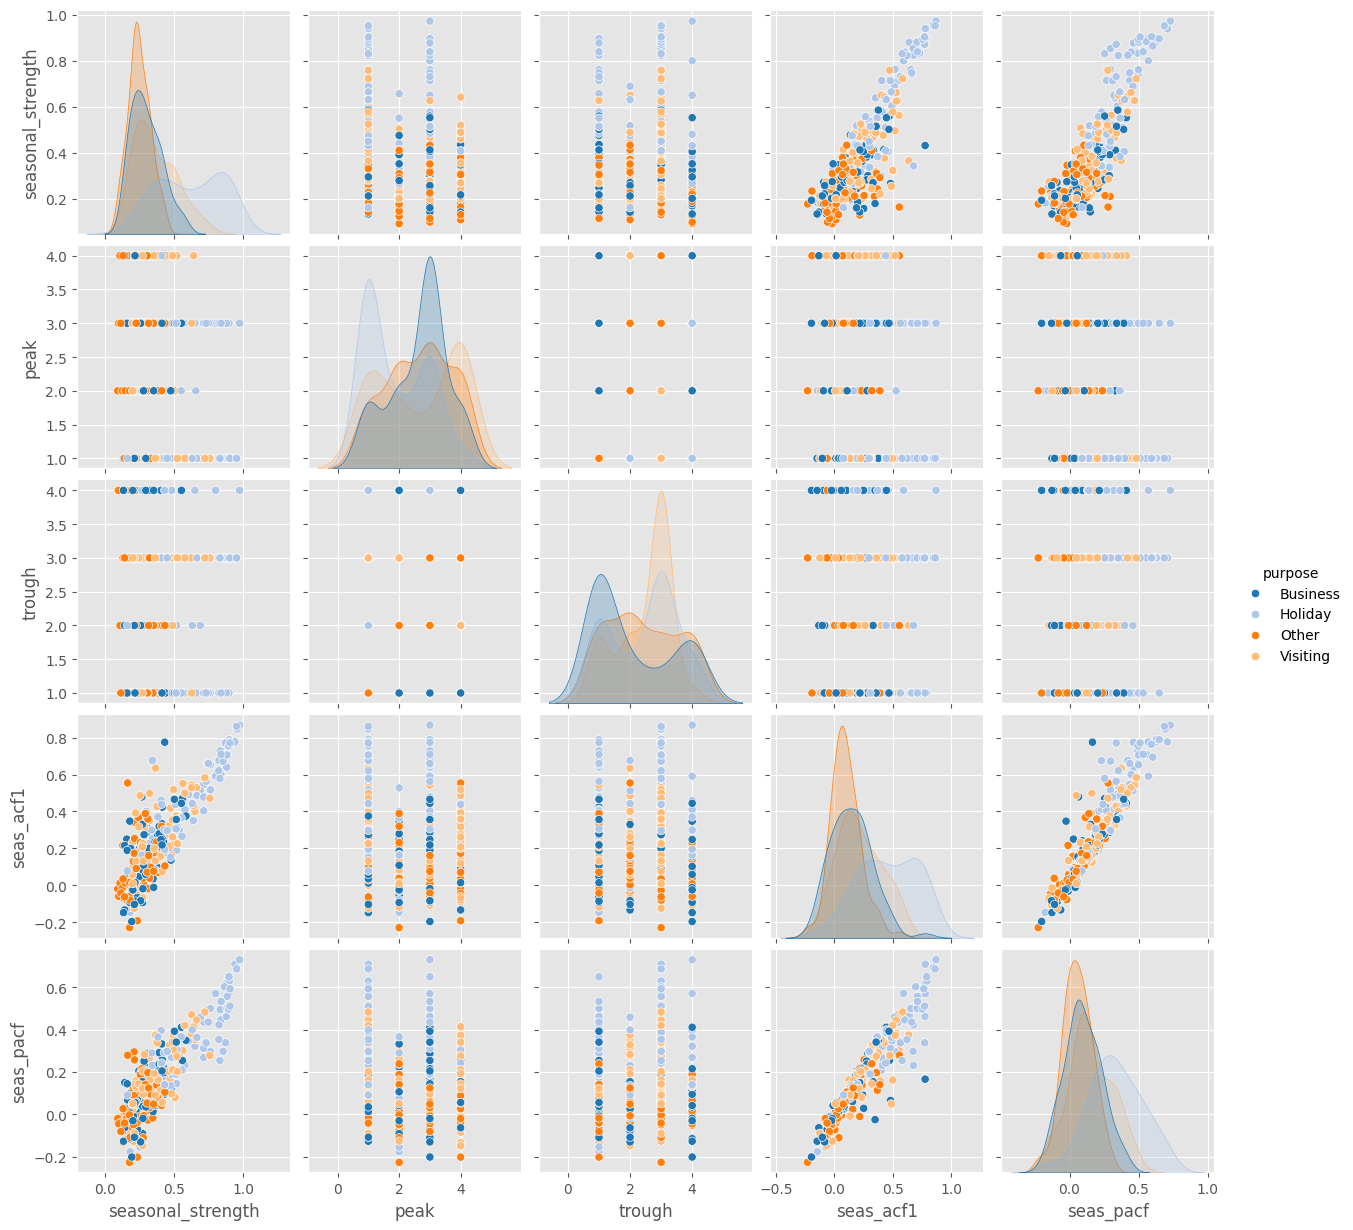

In [14]:
seasonal_feat = all_feat[
    ["unique_id", "seasonal_strength", "peak", "trough", "seas_acf1", "seas_pacf"]
]
seasonal_feat[["region", "state", "purpose"]] = seasonal_feat["unique_id"].str.split(
    "-", expand=True
)
g = sns.pairplot(seasonal_feat, hue="purpose")
plt.show()

In [15]:
all_features = [
    acf_features,
    arch_stat,
    crossing_points,
    entropy,
    flat_spots,
    heterogeneity,
    holt_parameters,
    lumpiness,
    nonlinearity,
    pacf_features,
    stl_features,
    stability,
    hw_parameters,
    unitroot_kpss,
    unitroot_pp,
    series_length,
    hurst,
]
all_feat = tsfeatures(aus_tourism, freq=4, features=all_features)
all_feat.head(10)

,unique_id,hurst,series_length,unitroot_pp,unitroot_kpss,hw_alpha,hw_beta,hw_gamma,stability,nperiods,...,entropy,crossing_points,arch_lm,x_acf1,x_acf10,diff1_acf1,diff1_acf10,diff2_acf1,diff2_acf10,seas_acf1
0,Adelaide Hills-South Australia-Business,NaN,80,-80.527,0.060,1.491e-08,1.520e-09,0.000e+00,0.294,1,...,0.895,36,0.014,0.071,0.134,-0.580,0.415,-0.750,0.746,-0.063
1,Adelaide Hills-South Australia-Holiday,0.823,80,-74.302,0.476,9.899e-02,9.899e-02,0.000e+00,0.409,1,...,0.831,33,0.121,0.131,0.313,-0.536,0.500,-0.716,0.906,0.208
2,Adelaide Hills-South Australia-Other,0.599,80,-55.385,0.605,1.490e-08,2.417e-09,1.799e-01,0.274,1,...,0.862,37,0.265,0.261,0.330,-0.253,0.317,-0.457,0.392,0.075
3,Adelaide Hills-South Australia-Visiting,0.757,80,-71.076,0.749,1.490e-08,3.758e-09,0.000e+00,0.333,1,...,0.907,25,0.005,0.139,0.117,-0.472,0.239,-0.626,0.408,0.170
4,Adelaide-South Australia-Business,0.840,80,-78.764,0.221,1.306e-01,1.306e-01,0.000e+00,0.318,1,...,0.848,43,0.183,0.033,0.131,-0.520,0.463,-0.676,0.741,0.201
5,Adelaide-South Australia-Holiday,0.709,80,-72.567,0.449,1.758e-01,1.758e-01,0.000e+00,0.312,1,...,0.737,36,0.161,0.046,0.372,-0.343,0.614,-0.487,0.558,0.351
6,Adelaide-South Australia-Other,0.776,80,-36.405,1.406,1.068e-01,7.719e-02,4.502e-12,0.574,1,...,0.755,28,0.456,0.517,1.154,-0.409,0.383,-0.675,0.792,0.342
7,Adelaide-South Australia-Visiting,0.737,80,-74.137,0.264,1.630e-01,3.258e-13,6.934e-12,0.267,1,...,0.776,42,0.173,0.068,0.294,-0.394,0.452,-0.518,0.447,0.345
8,Alice Springs-Northern Territory-Business,0.673,80,-65.845,0.807,1.456e-01,7.237e-12,0.000e+00,0.439,1,...,0.851,33,0.425,0.217,0.367,-0.500,0.381,-0.658,0.587,0.315
9,Alice Springs-Northern Territory-Holiday,0.579,80,-54.382,0.387,1.490e-08,3.004e-20,1.932e-13,0.084,1,...,0.412,40,0.304,-0.007,2.113,-0.153,2.113,-0.274,1.551,0.729


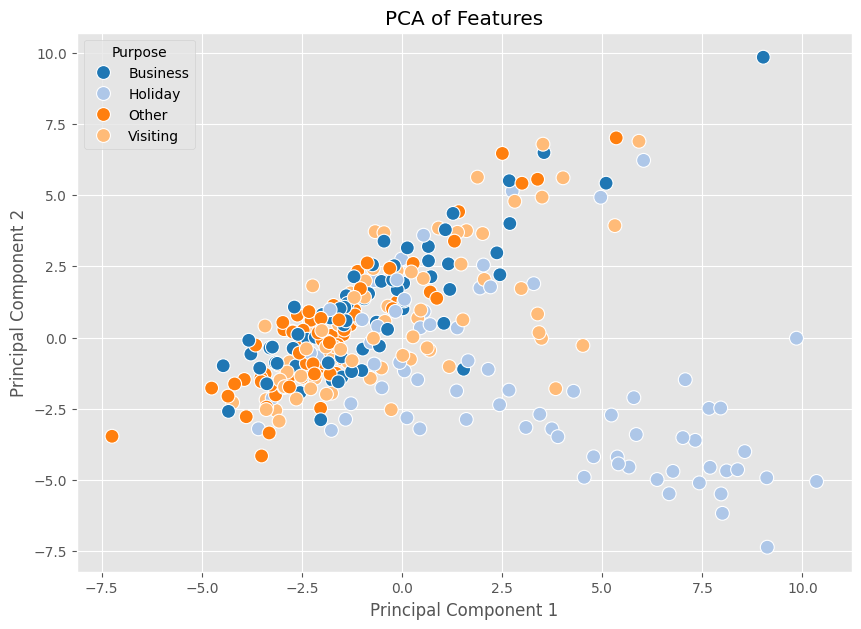

In [16]:
all_feat["purpose"] = all_feat["unique_id"].str.split("-").str[-1]
all_feat = all_feat.dropna(axis=1)

features = all_feat.columns.drop(["unique_id", "purpose"])
X = all_feat[features]
y = all_feat["purpose"]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

# Plotting the first two PCA components
pca_df = pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])
pca_df["purpose"] = y

plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="purpose", s=100)
plt.title("PCA of Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Purpose")
plt.show()

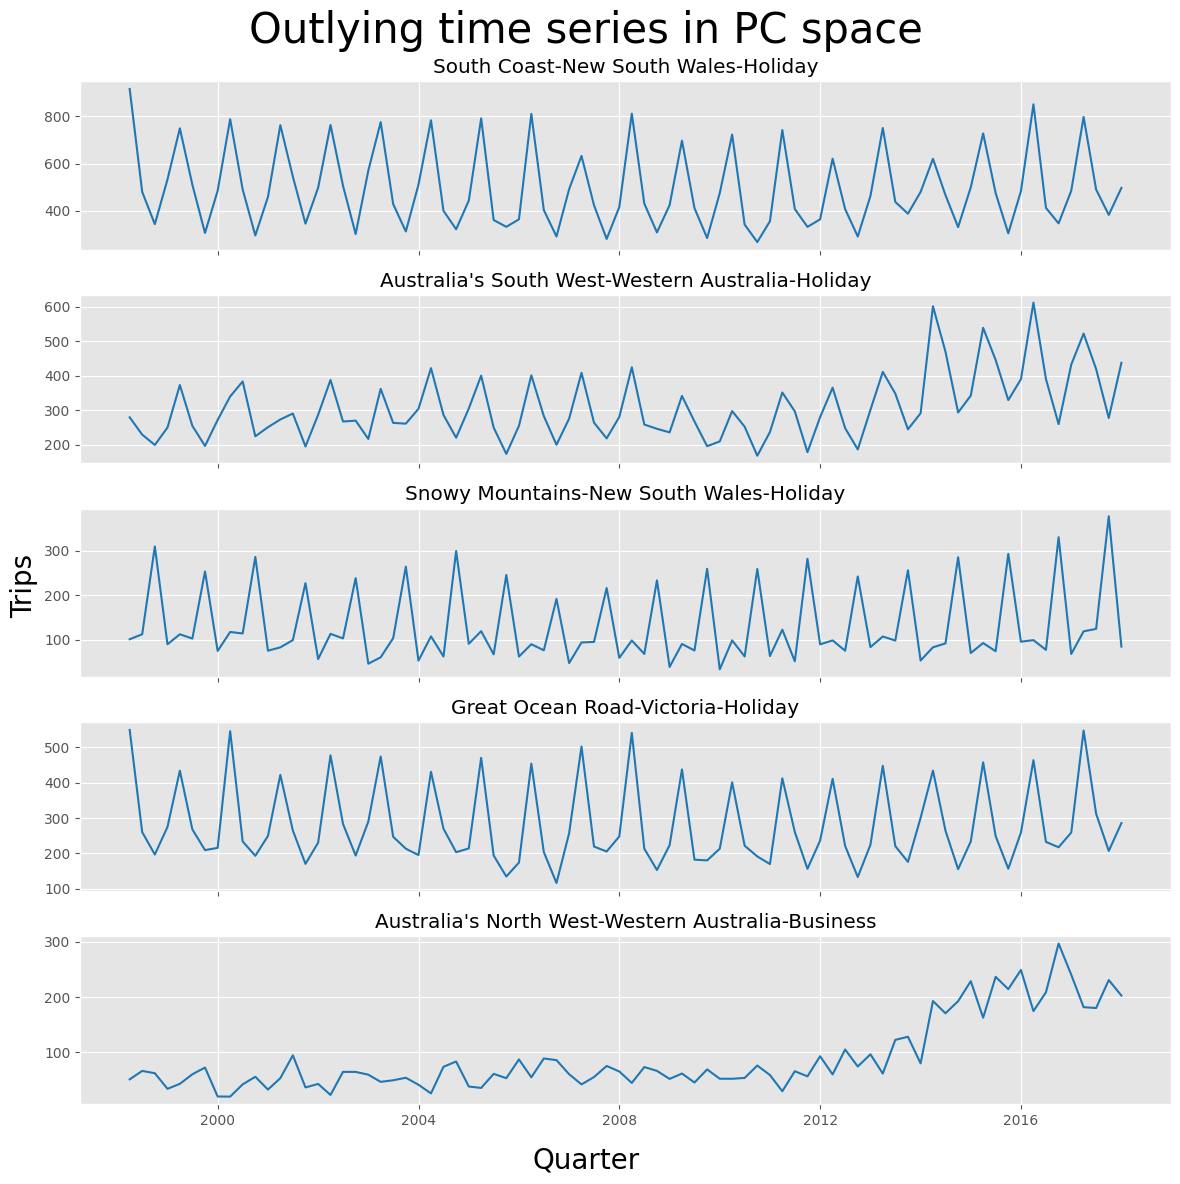

In [17]:
pca_df["unique_id"] = all_feat["unique_id"]
top_unique_ids = pca_df.nlargest(5, "PC1")["unique_id"]
plot_df = aus_tourism[aus_tourism["unique_id"].isin(top_unique_ids)]

fig, axs = plt.subplots(5, 1, figsize=(12, 12), sharex=True)

for i, unique_id in enumerate(top_unique_ids):
    subset = plot_df[plot_df["unique_id"] == unique_id]
    axs[i].plot(subset["ds"], subset["y"])
    axs[i].set_title(unique_id)
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")
fig.suptitle("Outlying time series in PC space", fontsize=30)
fig.supylabel("Trips", fontsize=20)
fig.supxlabel("Quarter", fontsize=20)
plt.tight_layout()
plt.show()

# [Exercises](https://otexts.com/fpppy/nbs/04-features.html#sec-feast-exercises)

## Question 1

In [18]:
pbs = pd.read_csv("data/PBS_unparsed.csv")
pbs["Month"] = pd.to_datetime(pbs["Month"])
pbs.head()

,Month,Concession,Type,ATC1,ATC1_desc,ATC2,ATC2_desc,Scripts,Cost
0,1991-07-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,18228,67877.0
1,1991-08-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,15327,57011.0
2,1991-09-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,14775,55020.0
3,1991-10-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,15380,57222.0
4,1991-11-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,14371,52120.0


In [19]:
pbs_feat = pbs.groupby(["Concession", "Type", "ATC1", "ATC2"])["Cost"].agg(
    [("mean", "mean"), ("std", "std")]
)
pbs_feat.head()

mean        std
Concession   Type        ATC1 ATC2                      
Concessional Co-payments A    A01   6.767e+04  1.476e+04
                              A02   1.646e+07  7.499e+06
                              A03   4.762e+05  3.707e+05
                              A04   4.634e+05  1.540e+05
                              A05   1.476e+05  7.419e+04

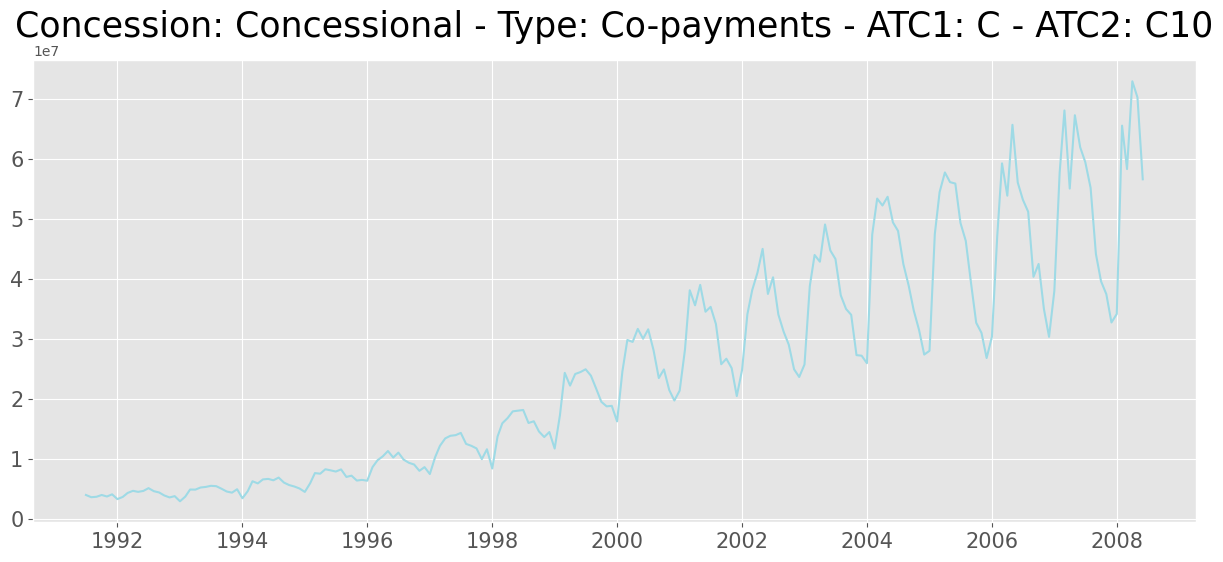

In [20]:
pbs_concession, pbs_type, pbs_atc1, pbs_atc2 = pbs_feat.loc[
    pbs_feat["mean"].idxmax()
].name
max_mean_rows = pbs[
    (pbs["Concession"] == pbs_concession)
    & (pbs["Type"] == pbs_type)
    & (pbs["ATC1"] == pbs_atc1)
    & (pbs["ATC2"] == pbs_atc2)
]
plot_series(
    df=max_mean_rows,
    id_col="Concession",
    time_col="Month",
    target_col="Cost",
    xlabel="",
    ylabel="",
    title=f"Concession: {pbs_concession} - Type: {pbs_type} - ATC1: {pbs_atc1} - ATC2: {pbs_atc2}",
)

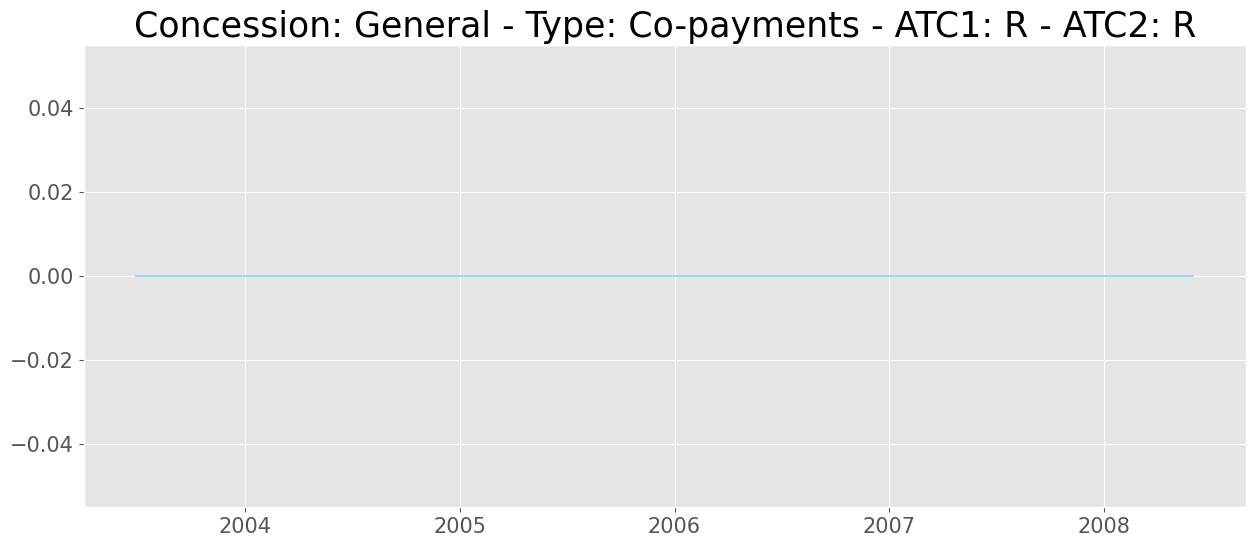

In [21]:
pbs_concession, pbs_type, pbs_atc1, pbs_atc2 = pbs_feat.loc[
    pbs_feat["std"].idxmin()
].name
min_std_rows = pbs[
    (pbs["Concession"] == pbs_concession)
    & (pbs["Type"] == pbs_type)
    & (pbs["ATC1"] == pbs_atc1)
    & (pbs["ATC2"] == pbs_atc2)
]
plot_series(
    df=min_std_rows,
    id_col="Concession",
    time_col="Month",
    target_col="Cost",
    xlabel="",
    ylabel="",
    title=f"Concession: {pbs_concession} - Type: {pbs_type} - ATC1: {pbs_atc1} - ATC2: {pbs_atc2}",
)

## Question 2

In [22]:
stl_feat = aus_tourism.groupby("unique_id", as_index=False)["y"].agg(
    [
        ("trend_strength", lambda x: get_trend_strength(x, period=4)),
        ("seasonal_strength", lambda x: get_seasonal_strength(x, period=4)),
        ("peak", lambda x: get_peak(x, period=4)),
        ("trough", lambda x: get_trough(x, period=4)),
        ("e_acf1", lambda x: get_e_acf1(x, period=4)),
        ("e_acf10", lambda x: get_e_acf10(x, period=4)),
    ]
)
stl_feat.head(10)

,unique_id,trend_strength,seasonal_strength,peak,trough,e_acf1,e_acf10
0,Adelaide Hills-South Australia-Business,0.460,0.168,3,4,-0.594,0.502
1,Adelaide Hills-South Australia-Holiday,0.531,0.295,2,4,-0.456,0.342
2,Adelaide Hills-South Australia-Other,0.590,0.407,2,2,-0.295,0.273
3,Adelaide Hills-South Australia-Visiting,0.487,0.248,4,3,-0.474,0.438
4,Adelaide-South Australia-Business,0.462,0.391,3,1,-0.538,0.577
5,Adelaide-South Australia-Holiday,0.578,0.638,1,2,-0.525,0.600
6,Adelaide-South Australia-Other,0.746,0.209,2,3,-0.368,0.412
7,Adelaide-South Australia-Visiting,0.449,0.476,1,2,-0.504,1.000
8,Alice Springs-Northern Territory-Business,0.552,0.302,3,1,-0.481,0.519
9,Alice Springs-Northern Territory-Holiday,0.379,0.832,3,1,-0.529,0.709


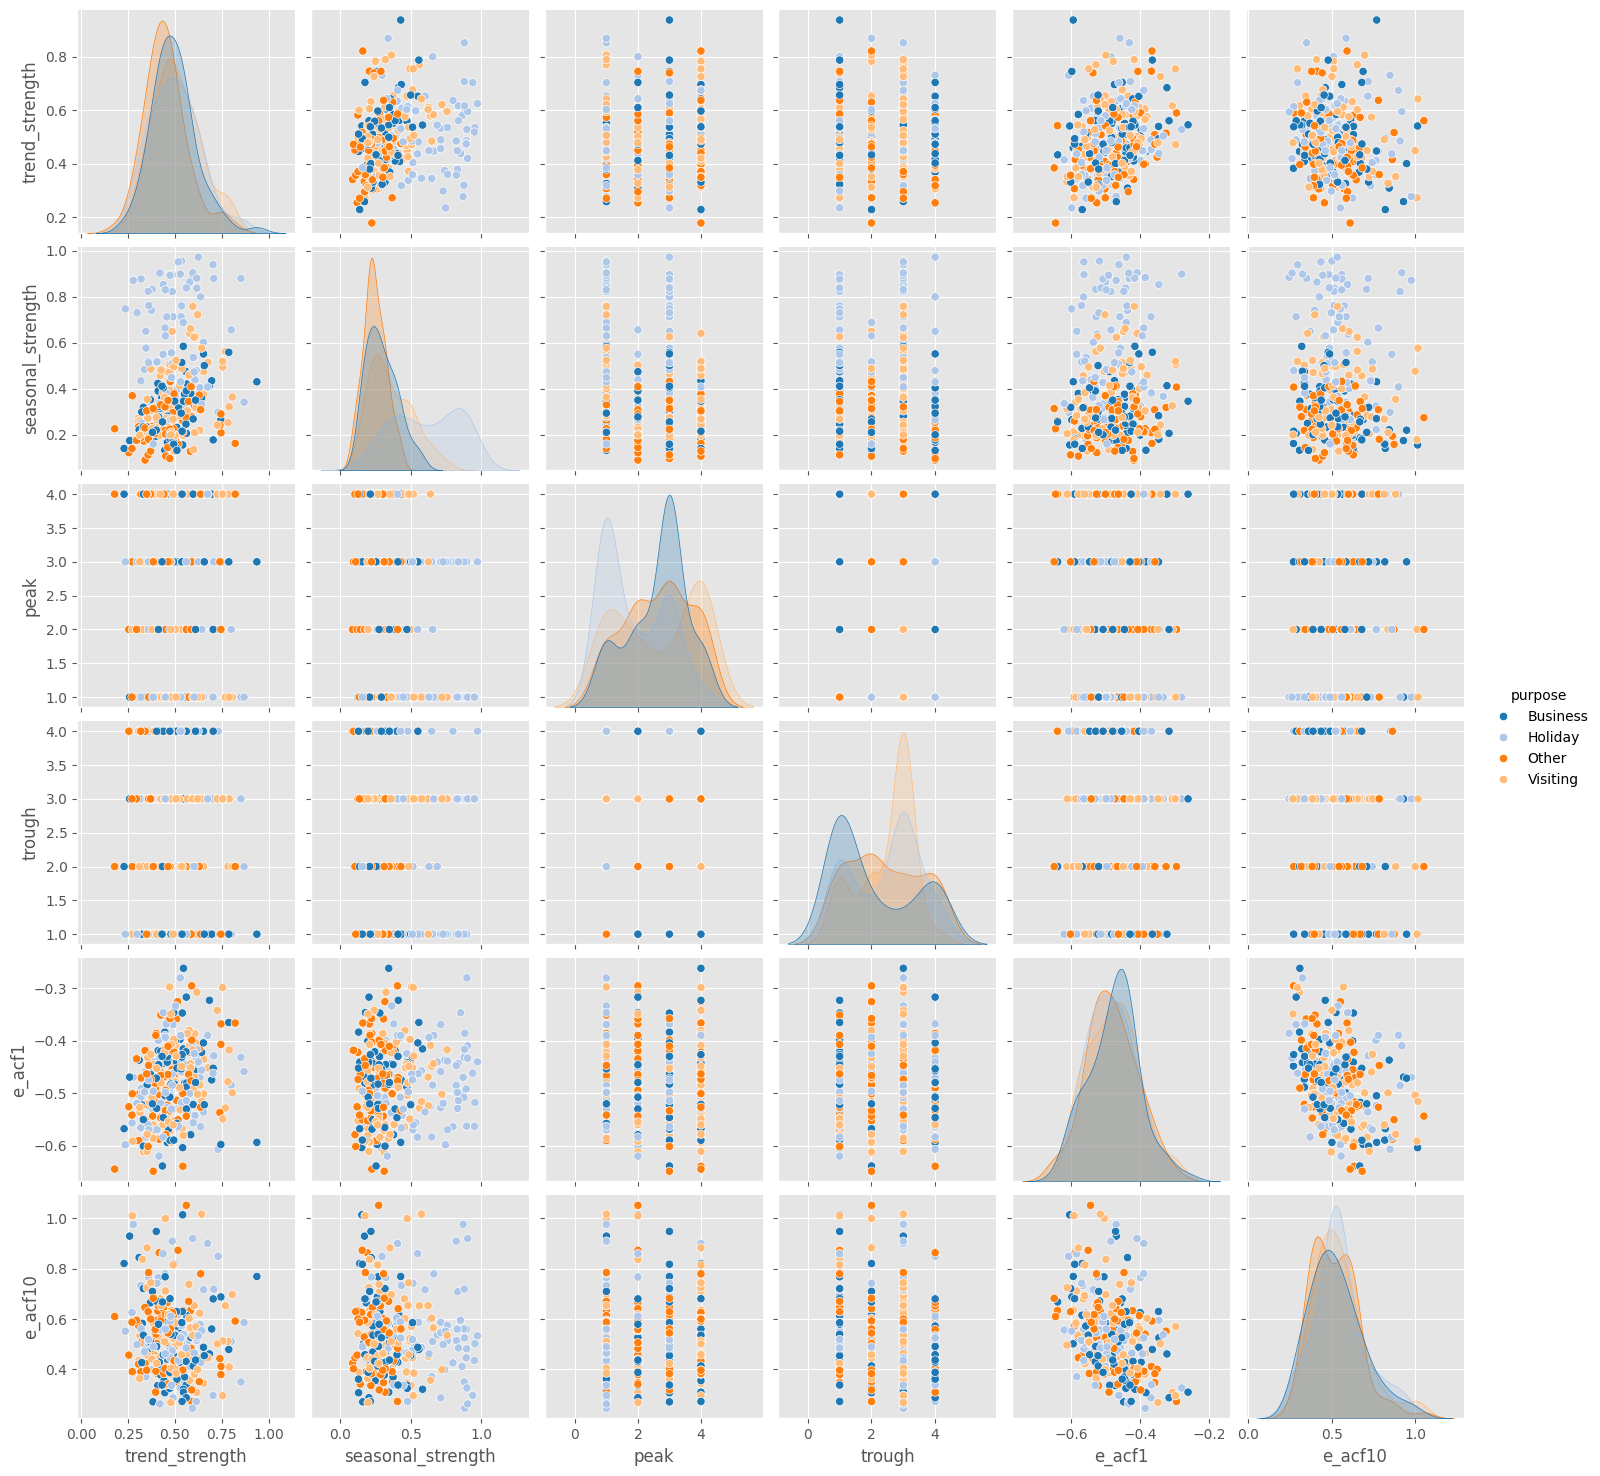

In [23]:
stl_feat[["region", "state", "purpose"]] = stl_feat["unique_id"].str.split(
    "-", expand=True
)
g = sns.pairplot(stl_feat, hue="purpose")
plt.show()

In [24]:
stl_feat[stl_feat["purpose"] == "Holiday"].groupby("state")["peak"].max()

state
ACT                   1
New South Wales       4
Northern Territory    3
Queensland            3
South Australia       4
Tasmania              1
Victoria              3
Western Australia     3
Name: peak, dtype: int64

## Question 3

In [25]:
pbs["unique_id"] = (
    pbs["Concession"] + "-" + pbs["Type"] + "-" + pbs["ATC1"] + "-" + pbs["ATC2"]
)
pbs.rename(columns={"Cost": "y"}, inplace=True)
pbs.head()

,Month,Concession,Type,ATC1,ATC1_desc,ATC2,ATC2_desc,Scripts,y,unique_id
0,1991-07-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,18228,67877.0,Concessional-Co-payments-A-A01
1,1991-08-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,15327,57011.0,Concessional-Co-payments-A-A01
2,1991-09-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,14775,55020.0,Concessional-Co-payments-A-A01
3,1991-10-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,15380,57222.0,Concessional-Co-payments-A-A01
4,1991-11-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,14371,52120.0,Concessional-Co-payments-A-A01


In [26]:
all_feat = tsfeatures(pbs, freq=12, features=all_features)
all_feat.head(10)

,unique_id,hurst,series_length,unitroot_pp,unitroot_kpss,hw_alpha,hw_beta,hw_gamma,stability,nperiods,...,entropy,crossing_points,arch_lm,x_acf1,x_acf10,diff1_acf1,diff1_acf10,diff2_acf1,diff2_acf10,seas_acf1
0,Concessional-Co-payments-A-A01,0.900,204,-57.084,0.725,0.335,8.264e-14,1.776e-01,0.344,1,...,0.442,37,0.587,0.737,0.996,0.021,0.151,-0.450,0.309,0.803
1,Concessional-Co-payments-A-A02,0.938,204,-23.415,3.253,0.185,2.991e-16,6.158e-01,0.716,1,...,0.463,27,0.798,0.904,3.663,0.128,0.402,-0.471,0.401,0.832
2,Concessional-Co-payments-A-A03,1.034,204,-9.841,1.522,1.000,0.000e+00,1.469e-08,0.896,1,...,0.240,12,0.841,0.961,6.457,0.170,0.390,-0.443,0.388,0.833
3,Concessional-Co-payments-A-A04,0.882,204,-23.199,2.938,0.380,0.000e+00,0.000e+00,0.732,1,...,0.549,23,0.574,0.873,3.529,-0.132,0.189,-0.613,0.562,0.704
4,Concessional-Co-payments-A-A05,NaN,96,-10.314,2.045,0.164,1.636e-01,6.405e-01,0.792,1,...,0.558,11,0.715,0.889,3.197,-0.034,0.334,-0.528,0.576,0.614
5,Concessional-Co-payments-A-A06,0.898,204,-35.485,2.512,0.157,4.469e-02,6.818e-01,0.550,1,...,0.495,27,0.722,0.864,2.166,0.158,0.415,-0.444,0.366,0.812
6,Concessional-Co-payments-A-A07,1.013,204,-18.467,3.554,0.092,8.707e-18,5.593e-01,0.775,1,...,0.491,25,0.796,0.908,4.266,-0.029,0.339,-0.566,0.577,0.805
7,Concessional-Co-payments-A-A09,0.917,204,-31.324,2.776,0.104,1.044e-01,3.843e-01,0.655,1,...,0.527,31,0.637,0.853,2.726,-0.116,0.273,-0.616,0.584,0.752
8,Concessional-Co-payments-A-A10,0.998,204,-15.979,3.508,0.111,3.451e-02,7.351e-01,0.778,1,...,0.498,13,0.865,0.919,4.294,0.104,0.416,-0.494,0.437,0.798
9,Concessional-Co-payments-A-A11,0.989,204,-12.140,0.932,0.172,1.717e-01,8.283e-01,0.892,1,...,0.203,12,0.833,0.950,5.993,0.137,0.411,-0.467,0.363,0.837


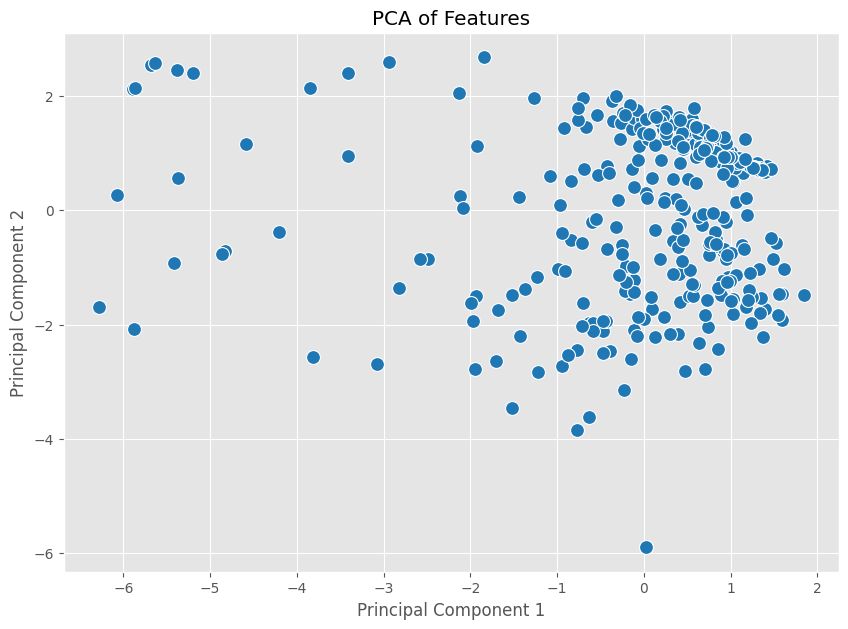

In [27]:
all_feat = all_feat.dropna(axis=1)

features = all_feat.columns.drop(["unique_id"])
X = all_feat[features]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

# Plotting the first two PCA components
pca_df = pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])

plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", s=100)
plt.title("PCA of Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [28]:
pca_df["abs_PC1"] = np.abs(pca_df["PC1"])
pca_df["abs_PC2"] = np.abs(pca_df["PC2"])
pca_df.head()

,PC1,PC2,abs_PC1,abs_PC2
0,0.468,0.017,0.468,0.017
1,0.912,-0.713,0.912,0.713
2,1.590,-1.468,1.590,1.468
3,0.185,-0.853,0.185,0.853
4,0.471,-2.809,0.471,2.809


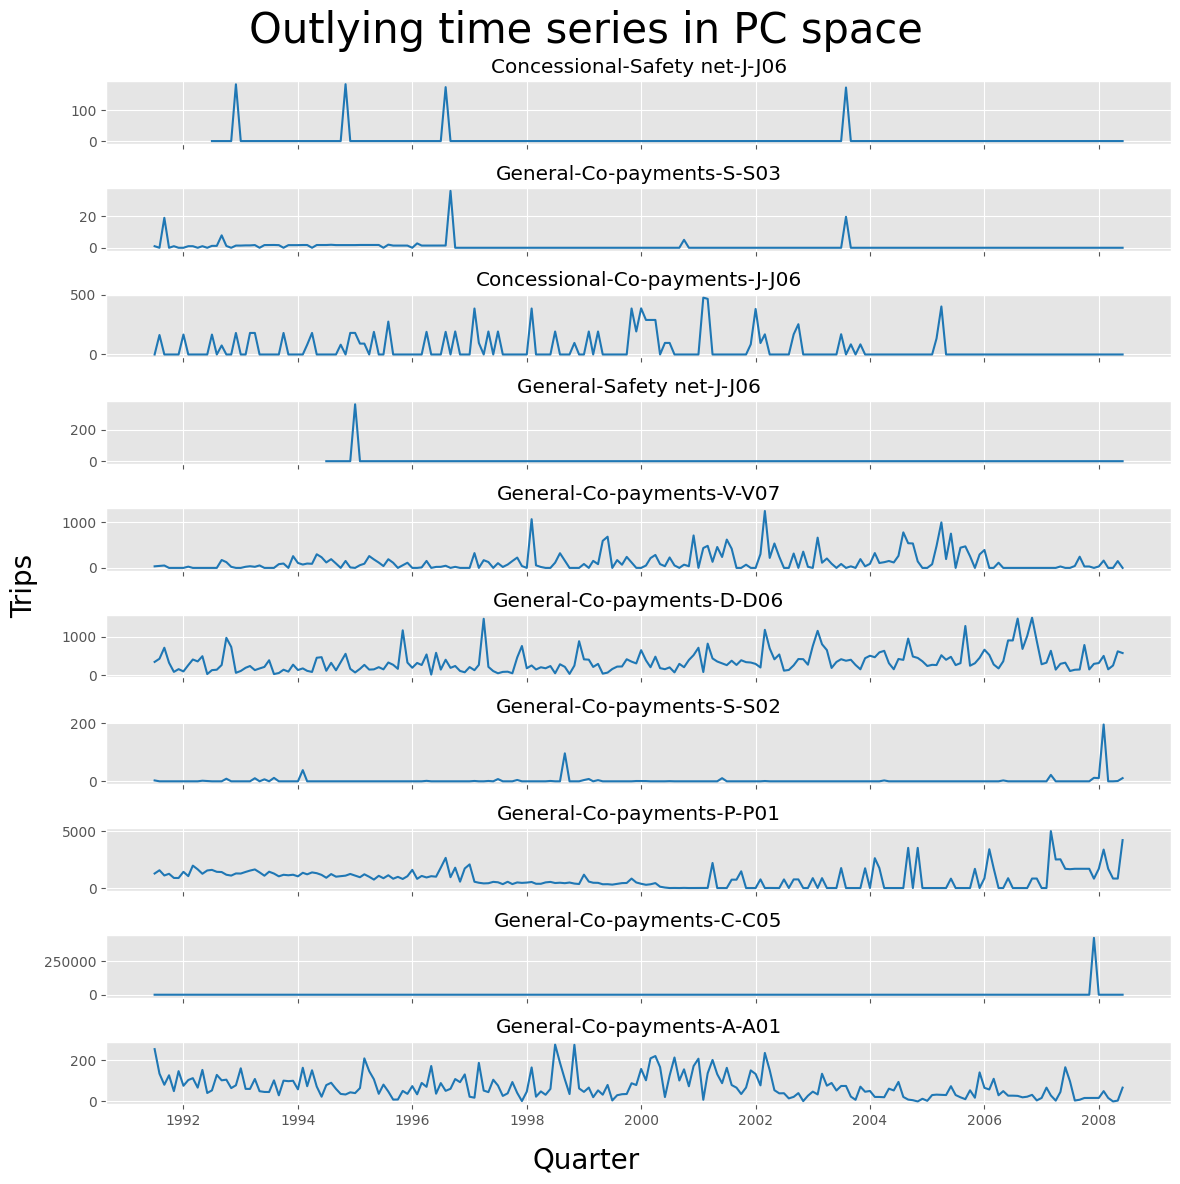

In [29]:
pca_df["unique_id"] = all_feat["unique_id"]
top_unique_ids = pca_df.nlargest(10, "abs_PC1")["unique_id"]
plot_df = pbs[pbs["unique_id"].isin(top_unique_ids)]

fig, axs = plt.subplots(10, 1, figsize=(12, 12), sharex=True)

for i, unique_id in enumerate(top_unique_ids):
    subset = plot_df[plot_df["unique_id"] == unique_id]
    axs[i].plot(subset["Month"], subset["y"])
    axs[i].set_title(unique_id)
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")
fig.suptitle("Outlying time series in PC space", fontsize=30)
fig.supylabel("Trips", fontsize=20)
fig.supxlabel("Quarter", fontsize=20)
plt.tight_layout()
plt.show()

We consider outliers are the series appearing the further out on the first PC on the PCA plot. 
- These time series don't show any trend or seasonality.
- Some of these time series only have a few values.